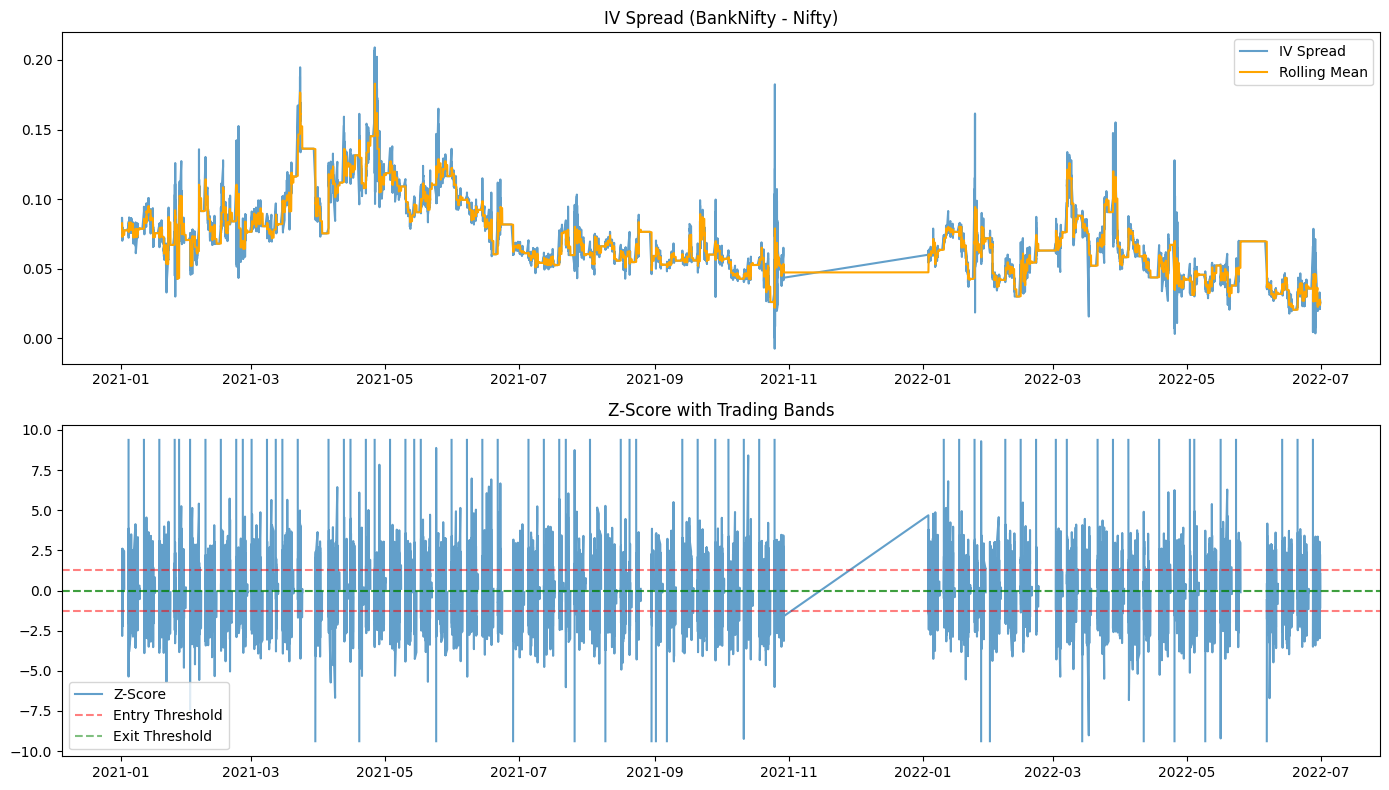

<ipython-input-2-96550674387c>:110: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['signal'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)



=== Strategy Performance ===
Total Return: 67.65
Annualized Return: 35.35
Annualized Volatility: 10.07
Sharpe Ratio: 3.51
Max Drawdown: 3.25
Number of Trades: 646


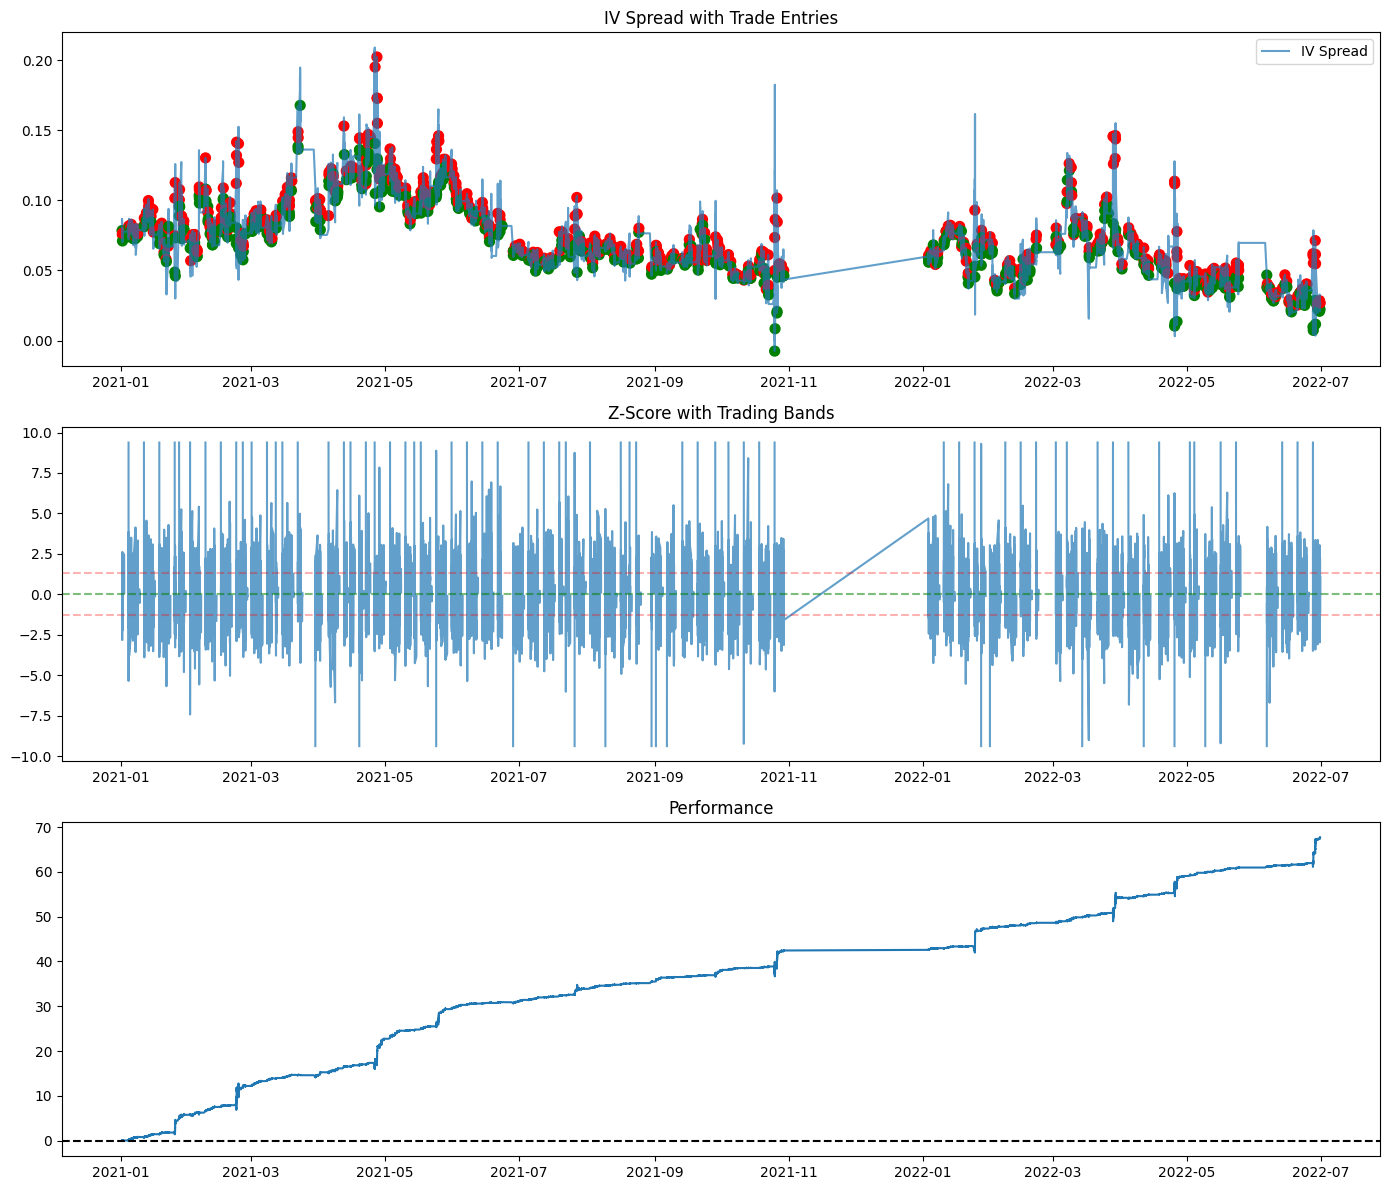

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import time, timedelta

class IVPairTradingStrategy:
    def __init__(self, lookback=375*3, z_entry=1.5, z_exit=0.5, tte_exponent=0.7,
                 min_holding=30, max_holding=375*5, trading_hours=(time(9,15), time(15,30))):
        self.lookback = lookback
        self.z_entry = z_entry
        self.z_exit = z_exit
        self.tte_exponent = tte_exponent
        self.min_holding = min_holding
        self.max_holding = max_holding
        self.trading_hours = trading_hours
        self.data = None
        self.results = None

    def load_data(self, filepath):
        self.data = pd.read_parquet(filepath)

        if not isinstance(self.data.index, pd.DatetimeIndex):
            if 'datetime' in self.data.columns:
                self.data.set_index('datetime', inplace=True)
            else:
                raise ValueError("Data must have datetime index or column")

        self.data = self.data.between_time(*self.trading_hours).sort_index()
        self.data[['banknifty', 'nifty', 'tte']] = self.data[['banknifty', 'nifty', 'tte']].ffill()
        self.data['iv_spread'] = self.data['banknifty'] - self.data['nifty']

        if self.data['iv_spread'].isna().any():
            raise ValueError("Spread calculation resulted in NA values")

    def calculate_zscores(self):
        min_periods = max(30, int(self.lookback * 0.1))
        self.data['spread_mean'] = self.data['iv_spread'].rolling(
            window=self.lookback, min_periods=min_periods).mean()
        self.data['spread_std'] = self.data['iv_spread'].rolling(
            window=self.lookback, min_periods=min_periods).std()
        self.data['z_score'] = (self.data['iv_spread'] - self.data['spread_mean']) / self.data['spread_std']

        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8))
        ax1.plot(self.data['iv_spread'], label='IV Spread', alpha=0.7)
        ax1.plot(self.data['spread_mean'], label='Rolling Mean', color='orange')
        ax1.set_title('IV Spread (BankNifty - Nifty)')
        ax1.legend()

        ax2.plot(self.data['z_score'], label='Z-Score', alpha=0.7)
        ax2.axhline(self.z_entry, color='r', linestyle='--', alpha=0.5, label='Entry Threshold')
        ax2.axhline(-self.z_entry, color='r', linestyle='--', alpha=0.5)
        ax2.axhline(self.z_exit, color='g', linestyle='--', alpha=0.5, label='Exit Threshold')
        ax2.axhline(-self.z_exit, color='g', linestyle='--', alpha=0.5)
        ax2.set_title('Z-Score with Trading Bands')
        ax2.legend()
        plt.tight_layout()
        plt.show()

    def generate_signals(self):
        df = self.data
        df['signal'] = 0
        df['entry_time'] = pd.NaT
        df['holding_period'] = 0.0

        in_trade = False
        entry_index = None
        entry_z = 0

        holding_counter = 0  # market time counter

        for i in range(1, len(df)):
            current_time = df.index[i]

            if in_trade:
                holding_counter += 1  # count market minutes
                df.at[current_time, 'holding_period'] = holding_counter

                current_z = df.at[current_time, 'z_score']
                exit_due_to_z = abs(current_z) <= self.z_exit
                exit_due_to_cross = (entry_z > 0 and current_z <= 0) or (entry_z < 0 and current_z >= 0)
                exit_due_to_max = holding_counter >= self.max_holding

                if holding_counter >= self.min_holding and (exit_due_to_z or exit_due_to_cross or exit_due_to_max):
                    in_trade = False
                    entry_index = None
                    entry_z = 0
                    holding_counter = 0  # reset counter
                    continue
                else:
                    df.at[current_time, 'signal'] = np.sign(entry_z) * -1
                    continue

            current_z = df.at[current_time, 'z_score']
            if current_z >= self.z_entry:
                df.at[current_time, 'signal'] = -1
                df.at[current_time, 'entry_time'] = current_time
                entry_z = current_z
                entry_index = current_time
                in_trade = True
                holding_counter = 0
            elif current_z <= -self.z_entry:
                df.at[current_time, 'signal'] = 1
                df.at[current_time, 'entry_time'] = current_time
                entry_z = current_z
                entry_index = current_time
                in_trade = True
                holding_counter = 0


        df['signal'] = df['signal'].replace(to_replace=0, method='ffill').fillna(0)
        self.data = df

    def calculate_pnl(self):
        self.data['spread_change'] = self.data['iv_spread'].diff()
        self.data['daily_pl'] = (
            self.data['signal'].shift(1) *
            self.data['spread_change'] *
            (self.data['tte'] ** self.tte_exponent))
        self.data['cumulative_pl'] = self.data['daily_pl'].cumsum()

    def backtest(self):
        self.calculate_zscores()
        self.generate_signals()
        self.calculate_pnl()

        total_minutes = len(self.data)
        total_days = total_minutes / (6.25 * 60)

        total_return = self.data['cumulative_pl'].iloc[-1]
        annualized_return = (total_return / total_days) * 252
        volatility = self.data['daily_pl'].std() * np.sqrt(252*6.25*60)
        sharpe_ratio = annualized_return / max(volatility, 1e-6)
        max_drawdown = (self.data['cumulative_pl'].cummax() - self.data['cumulative_pl']).max()

        trades = self.data[(self.data['signal'].diff().abs() > 0)]
        num_trades = len(trades) // 2

        self.results = {
            'total_return': total_return,
            'annualized_return': annualized_return,
            'volatility': volatility,
            'sharpe_ratio': sharpe_ratio,
            'max_drawdown': max_drawdown,
            'num_trades': num_trades}

        return self.results

    def plot_results(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 12))

        ax1.plot(self.data['iv_spread'], label='IV Spread', alpha=0.7)
        entries = self.data[self.data['signal'].diff().abs() > 0]
        colors = ['g' if s == 1 else 'r' for s in entries['signal']]
        ax1.scatter(entries.index, entries['iv_spread'], c=colors, s=50)
        ax1.set_title('IV Spread with Trade Entries')
        ax1.legend()

        ax2.plot(self.data['z_score'], label='Z-Score', alpha=0.7)
        ax2.axhline(self.z_entry, color='r', linestyle='--', alpha=0.3)
        ax2.axhline(-self.z_entry, color='r', linestyle='--', alpha=0.3)
        ax2.axhline(self.z_exit, color='g', linestyle='--', alpha=0.3)
        ax2.axhline(-self.z_exit, color='g', linestyle='--', alpha=0.3)
        ax2.set_title('Z-Score with Trading Bands')

        ax3.plot(self.data['cumulative_pl'], label='Cumulative PnL')
        ax3.axhline(0, color='black', linestyle='--')
        ax3.set_title("Performance")

        plt.tight_layout()
        plt.show()

if __name__ == "__main__":
    strategy = IVPairTradingStrategy(
        lookback=90, #aggressive strategy. I looked for a range of values between 375*3 mins to 90 mins
        z_entry=1.3,
        z_exit=0,
        tte_exponent=0.7,
        min_holding=30,
        max_holding=375*5
    )

    strategy.load_data('data.parquet')
    results = strategy.backtest()

    if results:
        print("\n=== Strategy Performance ===")
        print(f"Total Return: {results['total_return']:.2f}")
        print(f"Annualized Return: {results['annualized_return']:.2f}")
        print(f"Annualized Volatility: {results['volatility']:.2f}")
        print(f"Sharpe Ratio: {results['sharpe_ratio']:.2f}")
        print(f"Max Drawdown: {results['max_drawdown']:.2f}")
        print(f"Number of Trades: {results['num_trades']}")

        strategy.plot_results()
